# Hugging Face Transformers BERT fine-tuning using Amazon SageMaker and Training Compiler
### Compile and fine-tune a Multi-Class Classification Transformers with `Trainer` and `emotion` dataset using Amazon SageMaker Training Compiler

# Introduction

### SageMaker Training Compiler Overview

[SageMaker Training Compiler](https://docs.aws.amazon.com/sagemaker/latest/dg/training-compiler.html) optimizes DL models to accelerate training by more efficiently using SageMaker machine learning (ML) GPU instances. SageMaker Training Compiler is available at no additional charge within SageMaker and can help reduce total billable time as it accelerates training.

SageMaker Training Compiler is integrated into the AWS Deep Learning Containers (DLCs). Using the SageMaker Training Compiler enabled AWS DLCs, you can compile and optimize training jobs on GPU instances with minimal changes to your code. 

In this demo, we will use the Hugging Faces `transformers` and `datasets` library together with Amazon SageMaker and the new Amazon SageMaker Training Compiler to fine-tune a pre-trained transformer for multi-class text classification. In particular, the pre-trained model will be fine-tuned using the `emotion` dataset. To get started, we need to set up the environment with a few prerequisite steps, for permissions, configurations, and so on. 

![emotion-widget.png](./imgs/emotion-widget.png)

_**NOTE: You can run this demo in Sagemaker Studio, your local machine or Sagemaker Notebook Instances**_
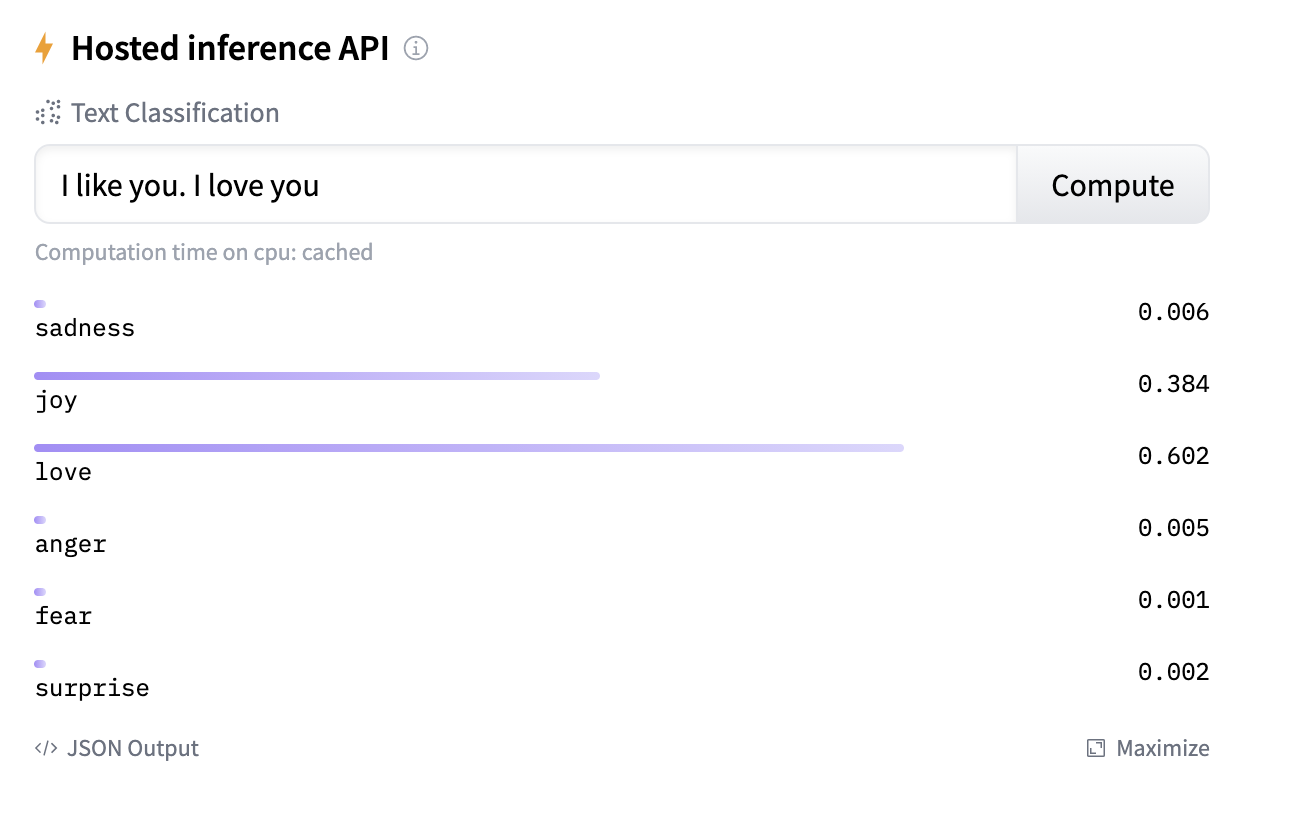

# Development Environment and Permissions 

## Installation

_*Note:* we only install the required libraries from Hugging Face and AWS. You also need PyTorch or Tensorflow, if you haven´t it installed_

In [ ]:
!pip install "sagemaker>=2.70.0" "transformers==4.11.0" --upgrade
# using older dataset due to incompatibility of sagemaker notebook & aws-cli with > s3fs and fsspec to >= 2021.10
!pip install  "datasets==1.13" --upgrade

In [ ]:
import sagemaker
assert sagemaker.__version__ >= "2.70.0"

In [ ]:
import sagemaker.huggingface

## Permissions

_If you are going to use Sagemaker in a local environment. You need access to an IAM Role with the required permissions for Sagemaker. You can find [here](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-roles.html) more about it._

In [ ]:
import sagemaker

sess = sagemaker.Session()
# sagemaker session bucket -> used for uploading data, models and logs
# sagemaker will automatically create this bucket if it not exists
sagemaker_session_bucket=None
if sagemaker_session_bucket is None and sess is not None:
    # set to default bucket if a bucket name is not given
    sagemaker_session_bucket = sess.default_bucket()

role = sagemaker.get_execution_role()
sess = sagemaker.Session(default_bucket=sagemaker_session_bucket)

print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket: {sess.default_bucket()}")
print(f"sagemaker session region: {sess.boto_region_name}")

# Preprocessing

We are using the `datasets` library to download and preprocess the `emotion` dataset. After preprocessing, the dataset will be uploaded to our `sagemaker_session_bucket` to be used within our training job. The [emotion](https://github.com/dair-ai/emotion_dataset) dataset consists of 16000 training examples, 2000 validation examples, and 2000 testing examples.

## Tokenization 

In [3]:
from datasets import load_dataset
from transformers import AutoTokenizer

# tokenizer used in preprocessing
model_id = 'bert-base-uncased'

# dataset used
dataset_name = 'emotion'

# s3 key prefix for the data
s3_prefix = 'samples/datasets/emotion'

In [4]:
# download tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_id)

# tokenizer helper function
def tokenize(batch):
    return tokenizer(batch['text'], padding='max_length', truncation=True)

# load dataset
train_dataset, test_dataset = load_dataset(dataset_name, split=['train', 'test'])

# tokenize dataset
train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

# set format for pytorch
train_dataset =  train_dataset.rename_column("label", "labels")
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset = test_dataset.rename_column("label", "labels")
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

Downloading: 3.62kB [00:00, 629kB/s]                    
Downloading: 3.28kB [00:00, 998kB/s]                    
Using custom data configuration default
Reusing dataset emotion (/Users/philipp/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705)
100%|██████████| 2/2 [00:00<00:00,  6.47ba/s]


## Uploading data to `sagemaker_session_bucket`

After we processed the `datasets` we are going to use the new `FileSystem` [integration](https://huggingface.co/docs/datasets/filesystems.html) to upload our dataset to S3.

In [5]:
import botocore
from datasets.filesystems import S3FileSystem

s3 = S3FileSystem()  

# save train_dataset to s3
training_input_path = f's3://{sess.default_bucket()}/{s3_prefix}/train'
train_dataset.save_to_disk(training_input_path, fs=s3)

# save test_dataset to s3
test_input_path = f's3://{sess.default_bucket()}/{s3_prefix}/test'
test_dataset.save_to_disk(test_input_path, fs=s3)

## Creating an Estimator and start a training job

The Amazon Training Compiler works best with Encoder Type models, like `BERT`, `RoBERTa`, `ALBERT`, `DistilBERT`. 

The Model compilation using Amazon SageMaker Training compiler increases efficiency and lowers the memory footprint of your Transformers model, which allows larger batch sizes and more efficient and faster training. 

We tested long classification tasks with `BERT`, `DistilBERT` and `RoBERTa and achieved up 33% higher batch sizes and 1.4x faster Training. For best performance, set batch size to a multiple of 8. 

The longer your training job, the larger the benefit of using Amazon SageMaker Training Compiler. 30 minutes seems to be the sweet spot to offset model compilation time in the beginning of your training. Initial pre-training jobs are excellent candidates for using the new Amazon SageMaker Training Compiler.



In [2]:
from sagemaker.huggingface import HuggingFace, TrainingCompilerConfig

# initialize the Amazon Training Compiler
compiler_config=TrainingCompilerConfig()


# hyperparameters, which are passed into the training job
hyperparameters={'epochs': 4,                                    # number of training epochs
                 'train_batch_size': 24,                         # batch size for training
                 'eval_batch_size': 32,                          # batch size for evaluation
                 'learning_rate': 3e-5,                          # learning rate used during training
                 'model_id':model_id,                            # pre-trained model
                 'fp16': True,                                   # Whether to use 16-bit (mixed) precision training
                }

# job name for sagemaker training 
job_name=f"training-compiler-{hyperparameters['model_id']}-{dataset_name}"


Create a `SageMakerEstimator` with the `SageMakerTrainingCompiler` and the `hyperparemters`, instance configuration and training script.

In [10]:
# create the Estimator
huggingface_estimator = HuggingFace(
    entry_point          = 'train.py',        # fine-tuning script used in training jon
    source_dir           = './scripts',       # directory where fine-tuning script is stored
    instance_type        = 'ml.p3.2xlarge',   # instances type used for the training job
    instance_count       = 1,                 # the number of instances used for training
    base_job_name        = job_name,          # the name of the training job
    role                 = role,              # Iam role used in training job to access AWS ressources, e.g. S3
    transformers_version = '4.11.0',          # the transformers version used in the training job
    pytorch_version      = '1.9.0',           # the pytorch_version version used in the training job
    py_version           = 'py38',            # the python version used in the training job
    hyperparameters      = hyperparameters,   # the hyperparameter used for running the training job
    compiler_config      = compiler_config,   # the compiler configuration used in the training job
    disable_profiler     = True,              # whether to disable the profiler during training used to gain maximum performance
    debugger_hook_config = False,             # whether to enable the debugger hook during training used to gain maximum performance
)

Start the training with the uploaded datsets on s3 with `huggingface_estimator.fit()`.

In [11]:
# define a data input dictonary with our uploaded s3 uris
data = {
    'train': training_input_path,
    'test': test_input_path
}

# starting the train job with our uploaded datasets as input
huggingface_estimator.fit(data)

## Deploying the endpoint

To deploy our endpoint, we call `deploy()` on our HuggingFace estimator object, passing in our desired number of instances and instance type.

In [ ]:
predictor = huggingface_estimator.deploy(1,"ml.g4dn.xlarge")

Then, we use the returned predictor object to call the endpoint.

In [ ]:
sentiment_input= {"inputs": "Winter is coming and it will be dark soon."}

predictor.predict(sentiment_input)

Finally, we delete the inference endpoint.

In [ ]:
predictor.delete_endpoint()